In [24]:
from shapely.geometry import Polygon
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import tifffile as tiff
import cv2 as cv
from aeronet.dataset import polygonize, rasterize, BandCollection, parse_directory, FeatureCollection
import os
from scipy import ndimage as ndi
from skimage.segmentation import watershed, mark_boundaries, find_boundaries
from skimage.morphology import binary_dilation
from skimage.exposure import equalize_adapthist, equalize_hist
from skimage.filters import gaussian, threshold_mean
from skimage.feature import peak_local_max

In [25]:
folder_name = 'West 92 d1'

In [27]:
INPUT_PATH = '/home/user/data/ilim_ortho/' + folder_name + '/polygon/'
test_image = '/home/user/data/ilim_data_05/test_image/bounding_box/'

## Split RGB image into channels, cut the polygon

In [28]:
# with rasterio.open(INPUT_PATH + 'West 47 d1.tif') as src:
#     img = src.read().transpose(1, 2, 0)
#     profile = src.profile

with rasterio.open(INPUT_PATH + 'RED.tif') as src:
    img1 = src.read()[0]
    profile = src.profile
profile.update(count=3)
with rasterio.open(INPUT_PATH + 'GRN.tif') as src:
    img2 = src.read()[0]
with rasterio.open(INPUT_PATH + 'BLU.tif') as src:
    img3 = src.read()[0]


with rasterio.open(test_image + 'test_image_bb.tif', 'w', **profile) as dst:
    dst.write(np.array([img1, img2, img3]))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: RasterioDeprecationWarning: Creation keywords stored on datasets by Rasterio versions < 1.0b1 will always be ignored in version 1.0. You may opt in to ignoring them now by setting RIO_IGNORE_CREATION_KWDS=TRUE in your environment.
  import sys


{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 21580, 'height': 28266, 'count': 3, 'crs': CRS({'init': 'epsg:32648'}), 'transform': Affine(0.051927899999998896, 0.0, 312801.1551254409,
       0.0, -0.05193039999998932, 6452345.256594489), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'pixel'}

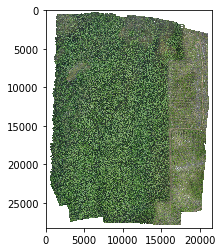

In [8]:
plt.imshow(img)
profile

In [12]:
img.shape

(28266, 21580, 3)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RasterioDeprecationWarning: Creation keywords stored on datasets by Rasterio versions < 1.0b1 will always be ignored in version 1.0. You may opt in to ignoring them now by setting RIO_IGNORE_CREATION_KWDS=TRUE in your environment.
  This is separate from the ipykernel package so we can avoid doing imports until


{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 13065, 'height': 15142, 'count': 3, 'crs': CRS({'init': 'epsg:32648'}), 'transform': Affine(0.04881150000000072, 0.0, 313079.1665801463,
       0.0, -0.04881709999999727, 6450003.887964794), 'tiled': False, 'interleave': 'band'}

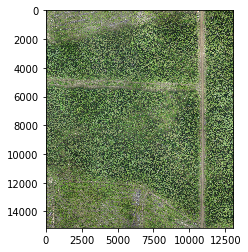

In [30]:
with rasterio.open(test_image + 'test_image_bb.tif') as src:
    img_test = src.read().transpose(1, 2, 0)
    profile_test = src.profile
plt.imshow(img_test)
profile_test

In [22]:
img_test.shape

(28266, 21580, 3)

In [28]:
# Actually, we have no problems as the data are the same
np.all(img == img_test)

True

# Trying to find difference via gdalinfo

In [24]:
! gdalinfo "/home/user/data/ilim_ortho/West 47 d1/Test_image.tif"

Driver: GTiff/GeoTIFF
Files: /home/user/data/ilim_ortho/West 47 d1/Test_image.tif
Size is 21580, 28266
Coordinate System is:
PROJCS["WGS 84 / UTM zone 48N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",105],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","32648"]]
Origin = (312801.155125440913253,6452345.256594489328563)
Pixel Size = (0.051927899999999,-0.05193039999998

In [26]:
! gdalinfo "/home/user/data/ilim_ortho/West 47 d1/West 47 d1.tif"

Driver: GTiff/GeoTIFF
Files: /home/user/data/ilim_ortho/West 47 d1/West 47 d1.tif
Size is 21580, 28266
Coordinate System is:
PROJCS["WGS 84 / UTM zone 48N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            TOWGS84[0,0,0,0,0,0,0],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0],
        UNIT["degree",0.0174532925199433],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",105],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AUTHORITY["EPSG","32648"]]
Origin = (312801.155125440913253,6452345.256594489328563)
Pixel Size = (0.051927899999999,-0.051930399999989)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  COMPRESSION=LZW
  INTERLEAVE=PIX

# The difference is that initial image has overviews 
https://gdal.org/drivers/raster/gtiff.html#overviews

# Test Image Preparation

In [17]:
INPUT_PATH = '/home/user/data/ilim_data_03/test_image/perm1_03/'

In [18]:
with rasterio.open(INPUT_PATH + 'RED.tif') as src:
    RED = src.read()[0]
    profile = src.profile
profile.update(count=3)

with rasterio.open(INPUT_PATH + 'GRN.tif') as src:
    GRN = src.read()[0]
    
with rasterio.open(INPUT_PATH + 'BLU.tif') as src:
    BLU = src.read()[0]

with rasterio.open(INPUT_PATH + 'test_img.tif', 'w', **profile) as dst:
    dst.write(np.array([RED, GRN, BLU]))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RasterioDeprecationWarning: Creation keywords stored on datasets by Rasterio versions < 1.0b1 will always be ignored in version 1.0. You may opt in to ignoring them now by setting RIO_IGNORE_CREATION_KWDS=TRUE in your environment.
  This is separate from the ipykernel package so we can avoid doing imports until


In [20]:
with rasterio.open(INPUT_PATH + 'bounds.tif') as src:
    bounds = src.read()[0]
    profile = src.profile
profile.update(count=3)

with rasterio.open(INPUT_PATH + 'trees.tif') as src:
    trees = src.read()[0]
    
with rasterio.open(INPUT_PATH + 'bg.tif') as src:
    bg = src.read()[0]

with rasterio.open(INPUT_PATH + 'mask.tif', 'w', **profile) as dst:
    dst.write(np.array([bounds, trees, bg]))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RasterioDeprecationWarning: Creation keywords stored on datasets by Rasterio versions < 1.0b1 will always be ignored in version 1.0. You may opt in to ignoring them now by setting RIO_IGNORE_CREATION_KWDS=TRUE in your environment.
  This is separate from the ipykernel package so we can avoid doing imports until


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RasterioDeprecationWarning: Creation keywords stored on datasets by Rasterio versions < 1.0b1 will always be ignored in version 1.0. You may opt in to ignoring them now by setting RIO_IGNORE_CREATION_KWDS=TRUE in your environment.
  This is separate from the ipykernel package so we can avoid doing imports until


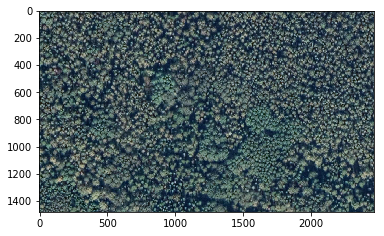

In [19]:
with rasterio.open(INPUT_PATH + 'test_img.tif') as src:
    img = src.read().transpose(1, 2, 0)
    profile = src.profile
plt.imshow(img)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RasterioDeprecationWarning: Creation keywords stored on datasets by Rasterio versions < 1.0b1 will always be ignored in version 1.0. You may opt in to ignoring them now by setting RIO_IGNORE_CREATION_KWDS=TRUE in your environment.
  This is separate from the ipykernel package so we can avoid doing imports until


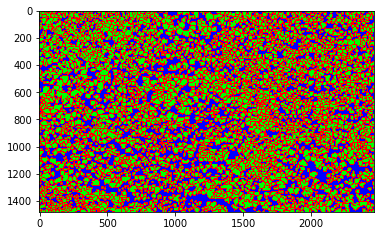

In [21]:
with rasterio.open(INPUT_PATH + 'mask.tif') as src:
    img = src.read().transpose(1, 2, 0)
    profile = src.profile
plt.imshow(img*255)

In [39]:
profile

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 2048, 'height': 794, 'count': 3, 'crs': CRS({'init': 'epsg:32648'}), 'transform': Affine(0.31, 0.0, 313079.1665801463,
       0.0, -0.31, 6450003.887964794), 'tiled': False, 'interleave': 'band'}

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f909b355fd0>)

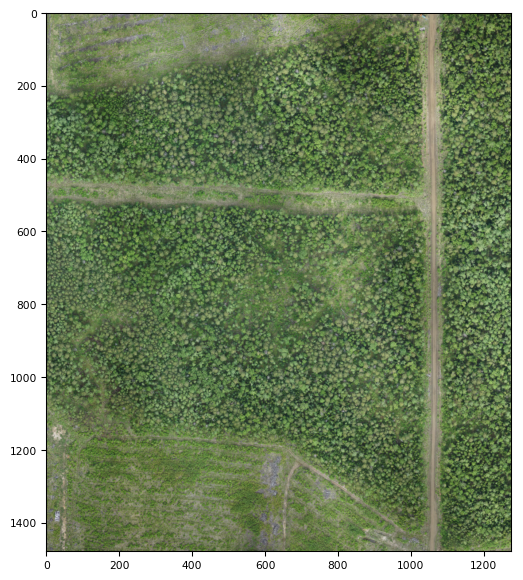

In [7]:
tiff.imshow(np.array([RED, GRN, BLU]))

In [9]:
.shape

(3, 1478, 1275)

# Perm1 orthophoto resize

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
import tifffile as tiff
import rasterio
from skimage.segmentation import watershed
from skimage.segmentation import find_boundaries
from skimage.morphology import binary_dilation, binary_erosion, remove_small_objects, remove_small_holes
from skimage.filters import gaussian, threshold_otsu
from skimage.feature import peak_local_max
from skimage.exposure import equalize_adapthist
import cv2 as cv

In [2]:
def image_resize(input_path, img_name, px_size = 0.5):
    with rasterio.open(input_path + img_name + '.tif') as src:
        img = src.read()[0]
        profile = src.profile
    
#     img_resize = cv.resize(img, dsize=(orig_shape[1], orig_shape[0]), interpolation=cv.INTER_NEAREST)
    img_resize = cv.resize(img, None, fx=(profile['transform'][0]/px_size), fy=(-profile['transform'][4]/px_size), interpolation=cv.INTER_NEAREST)
    
    profile.update(transform=rasterio.Affine(px_size, 0.0, profile['transform'][2], 0.0, -px_size, profile['transform'][5]), 
               width = img_resize.shape[1], height = img_resize.shape[0])
    return img_resize, profile

def image_save(output_path, img, img_name, profile):
    with rasterio.open(output_path + img_name + '.tif', 'w', **profile) as dst:
        dst.write(img, 1)

In [3]:
INPUT_PATH = '/home/user/data/ilim_data_03/test_image/perm1_03/'

In [9]:
mask_trees_resize, profile_resize = image_resize(INPUT_PATH, 'trees', 0.31)
mask_bg_resize, _ = image_resize(INPUT_PATH, 'bg', 0.31)
mask_bounds_resize, _ = image_resize(INPUT_PATH, 'bounds', 0.31)

small_obj_size2 = 10
mask_trees_resize = remove_small_objects(mask_trees_resize > 0, min_size=small_obj_size2).astype(np.uint8)
mask_bounds_resize[np.where((mask_trees_resize == 0) & (mask_bg_resize == 0))] = 1
# mask_bounds_resize = np.array((mask_trees_resize == False) & (mask_bg_resize == False)).astype(np.uint8)
# kernel = np.ones((2,2),np.uint8)
# mask_bounds_resize = cv.dilate(mask_bounds_resize, kernel, iterations=1)
# mask_trees_resize[mask_bounds_resize == 1] = 0
# mask_bg_resize[mask_bounds_resize == 1] = 0

image_save(INPUT_PATH, mask_trees_resize, 'trees2', profile_resize)
image_save(INPUT_PATH, mask_bg_resize, 'bg2', profile_resize)
image_save(INPUT_PATH, mask_bounds_resize, 'bounds2', profile_resize)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RasterioDeprecationWarning: Creation keywords stored on datasets by Rasterio versions < 1.0b1 will always be ignored in version 1.0. You may opt in to ignoring them now by setting RIO_IGNORE_CREATION_KWDS=TRUE in your environment.
  after removing the cwd from sys.path.


In [13]:
print(mask_bg_resize.sum() + mask_trees_resize.sum() + mask_bounds_resize.sum(), mask_bg_resize.size, mask_bg_resize.sum() + mask_trees_resize.sum() + mask_bounds_resize.sum() == mask_bg_resize.size)
# print(mask_bg_resize.sum() + mask_trees_resize.sum() + mask_bounds_resize.sum())

q, w = ndi.label(mask_trees_resize)
print(w)

3655108 3655108 True
4017


In [14]:
mask_trees_resize, profile_resize = image_resize(INPUT_PATH, 'RED', 0.31)
mask_bg_resize, _ = image_resize(INPUT_PATH, 'GRN', 0.31)
mask_bounds_resize, _ = image_resize(INPUT_PATH, 'BLU', 0.31)

image_save(INPUT_PATH, mask_trees_resize, 'RED2', profile_resize)
image_save(INPUT_PATH, mask_bg_resize, 'GRN2', profile_resize)
image_save(INPUT_PATH, mask_bounds_resize, 'BLU2', profile_resize)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RasterioDeprecationWarning: Creation keywords stored on datasets by Rasterio versions < 1.0b1 will always be ignored in version 1.0. You may opt in to ignoring them now by setting RIO_IGNORE_CREATION_KWDS=TRUE in your environment.
  after removing the cwd from sys.path.


In [15]:
print(mask_bg_resize.sum() + mask_trees_resize.sum() + mask_bounds_resize.sum(), mask_bg_resize.size, mask_bg_resize.sum() + mask_trees_resize.sum() + mask_bounds_resize.sum() == mask_bg_resize.size)
# print(mask_bg_resize.sum() + mask_trees_resize.sum() + mask_bounds_resize.sum())

q, w = ndi.label(mask_trees_resize)
print(w)

847096274 3655108 False
1
